In [1]:
import torchvision
print(torchvision.__version__)

0.19.0


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import os
from pathlib import Path
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

In [3]:
def split_folder(folder):
    data = []
    sub_folder = list(sorted(os.listdir(folder)))
    sub_folder_path = [os.path.join(folder, sub) for sub in sub_folder]
    file = ["jpg", "png", "jpeg"]
    for folder_path in sub_folder_path:
        image = list(sorted(os.listdir(folder_path)))
        for img in image:
            img_path = os.path.join(folder_path, img)
            try:
                img_pil = Image.open(img_path)
                if img_pil.mode != "P" or img_pil.split(".")[-1] in file:
                    data.append(img_path)
            except:
                continue

    class_name = {i:label for i, label in enumerate(sub_folder)}
    return data, class_name

In [4]:
class MyDataSet(nn.Module):
    def __init__(self, folder, transforms=None):
        super(MyDataSet, self).__init__()
        self.image, self.class_name = split_folder(folder)
        self.transforms = transforms
        self.label_to_idx = {self.class_name[i]: i for i in range(len(self.class_name))}
    def load_image(self, index):
        img = Image.open(self.image[index])
        img = img.convert("RGB")
        return img
    def __len__(self):
        return len(self.image)
    def __getitem__(self, index):
        img = self.load_image(index)
        label = Path(self.image[index]).parent.name
        if self.transforms is not None:
            img = self.transforms(img)
            return img, self.label_to_idx[label]
        return img, self.label_to_idx[label]

In [5]:
img_size = 224
train_transform = transforms.Compose([transforms.Resize((img_size,img_size)),
                                    transforms.CenterCrop(img_size),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
val_transform = transforms.Compose([transforms.Resize((img_size,img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [6]:
train_data = MyDataSet(folder="/kaggle/input/vn-moto-dataset", transforms=train_transform)
val_data = MyDataSet(folder="/kaggle/input/tiny-moto-dataset", transforms=val_transform)

In [7]:
print(f"Class name: {train_data.class_name}")
print(f"Shape of image 1: {train_data[0][0].shape}")
print(f"Label: {train_data[0][1]}")

Class name: {0: 'Honda', 1: 'Others', 2: 'Suzuki', 3: 'VinFast', 4: 'Yamaha'}
Shape of image 1: torch.Size([3, 224, 224])
Label: 0


In [8]:
sub_folder = list(sorted(os.listdir("/kaggle/input/vn-moto-dataset")))
classes, count = [], []
for folder in sub_folder:
    classes.append(folder)
    folder_path = os.path.join("/kaggle/input/vn-moto-dataset", folder)
    count.append(len(list(sorted(os.listdir(folder_path)))))

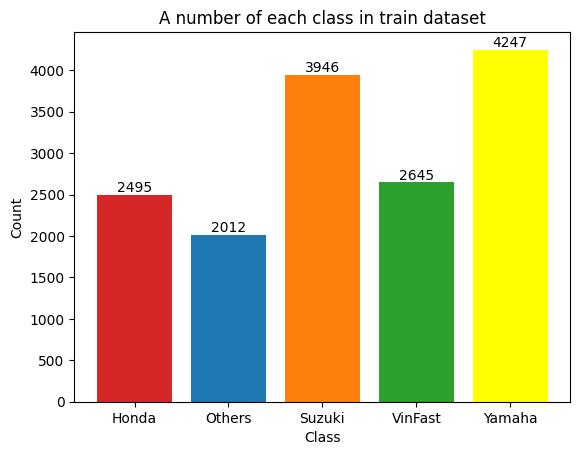

In [9]:
fig, ax = plt.subplots()
bar_color = ["tab:red", "tab:blue", "tab:orange", "tab:green", "#FFFF00"]
bars = ax.bar(classes, count, color=bar_color)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, int(height),
           ha="center", va="bottom")

ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.set_title("A number of each class in train dataset")

plt.show()

# 1. Prepare Dataset

In [10]:
BATCH_SIZE = 16
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)
val_dataloader = DataLoader(dataset=val_data,
                           batch_size=BATCH_SIZE,
                           shuffle=True)

# 2. Data Augmentation

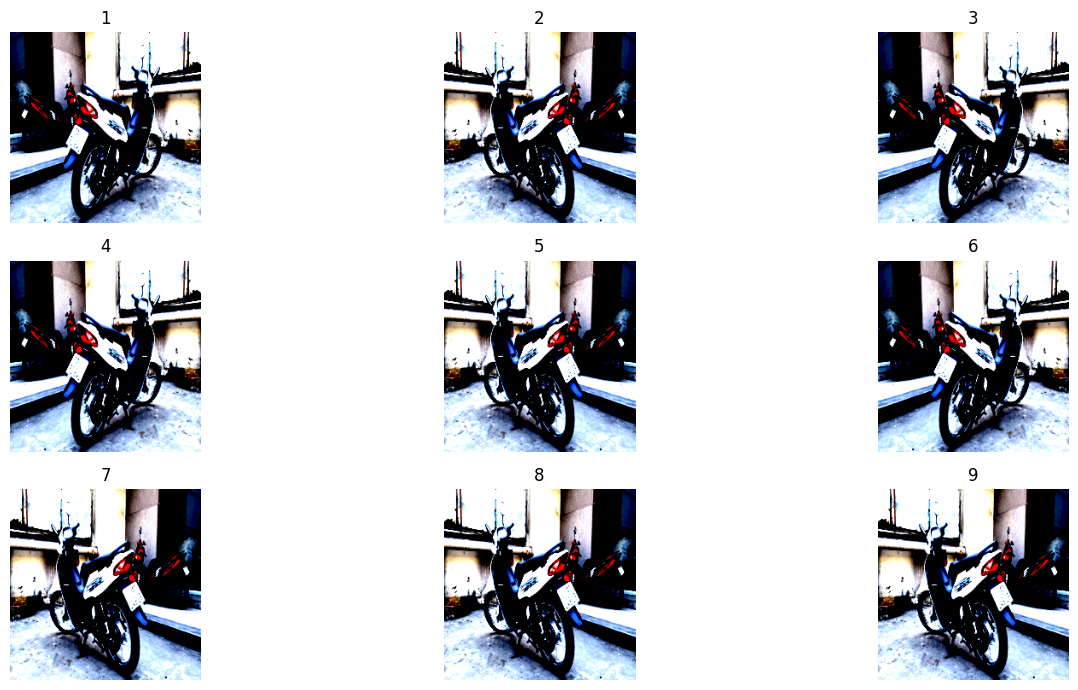

In [11]:
plt.figure(figsize=(15, 7))
for i in range(1, 10):
    image_numpy = torch.Tensor.numpy(train_data[0][0].permute(1, 2, 0))
    plt.subplot(3, 3, i)
    plt.imshow(image_numpy)
    plt.title(f"{i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 3. Model

In [12]:
class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """

    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape), requires_grad=True)
        self.bias = nn.Parameter(torch.zeros(normalized_shape), requires_grad=True)
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise ValueError(f"not support data format '{self.data_format}'")
        self.normalized_shape = (normalized_shape,)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            # [batch_size, channels, height, width]
            mean = x.mean(1, keepdim=True)
            var = (x - mean).pow(2).mean(1, keepdim=True)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

In [13]:
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


In [14]:
class GRN(nn.Module):
    """ GRN (Global Response Normalization) layer
    """
    def __init__(self, dim):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        Gx = torch.norm(x, p=2, dim=(1,2), keepdim=True)
        Nx = Gx / (Gx.mean(dim=-1, keepdim=True) + 1e-6)
        return self.gamma * (x * Nx) + self.beta + x

In [15]:
class Block(nn.Module):
    """ ConvNeXtV2 Block.
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
    """
    def __init__(self, dim, drop_path=0.):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.grn = GRN(4 * dim) 
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

In [16]:
class ConvNextV2(nn.Module):
    """ ConvNeXt V2
        
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], 
                 drop_path_rate=0., head_init_scale=1.
                 ):
        super().__init__()
        self.depths = depths
        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=3, stride=3),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j]) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)
        # self.head = nn.Sequential(
        #     nn.Linear(dims[-1], 2048, bias=True),
        #     nn.LayerNorm(2048),
        #     nn.ReLU(),
        #     nn.Dropout(0.1),
        #     nn.Linear(2048, 2048),
        #     nn.LayerNorm(2048),
        #     nn.ReLU(),
        #     nn.Linear(2048, num_classes)
        # )

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        x = self.norm(x.mean([-2, -1]))
        x = self.head(x)

        return x

In [17]:
torch.manual_seed(42)
NUM_CLASSES = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
model_cls = ConvNextV2(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], num_classes=NUM_CLASSES)

In [18]:
model_cls

ConvNextV2(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(3, 3))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (grn): GRN()
        (pwconv2): Linear(in_features=384, out_features=96, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), s

In [19]:
from torchinfo import summary
print(summary(model_cls))

Layer (type:depth-idx)                   Param #
ConvNextV2                               --
├─ModuleList: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  2,688
│    │    └─LayerNorm: 3-2               192
│    └─Sequential: 2-2                   --
│    │    └─LayerNorm: 3-3               192
│    │    └─Conv2d: 3-4                  73,920
│    └─Sequential: 2-3                   --
│    │    └─LayerNorm: 3-5               384
│    │    └─Conv2d: 3-6                  295,296
│    └─Sequential: 2-4                   --
│    │    └─LayerNorm: 3-7               768
│    │    └─Conv2d: 3-8                  1,180,416
├─ModuleList: 1-2                        --
│    └─Sequential: 2-5                   --
│    │    └─Block: 3-9                   79,968
│    │    └─Block: 3-10                  79,968
│    │    └─Block: 3-11                  79,968
│    └─Sequential: 2-6                   --
│    │    └─Block: 3-12             

In [20]:
torch.manual_seed(42)
model_cls.eval()
image = train_data[0][0]
model_cls, image = model_cls.to(device), image.to(device)
print(model_cls(image.unsqueeze(0)))

tensor([[-0.0225,  0.7402, -0.2936, -0.4129,  0.5960]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


# 4. Training

In [21]:
def accuracy_fn(y_true, y_pred):
    acc = torch.eq(y_true, y_pred).sum().item()
    return (acc / len(y_true)) 

In [22]:
def train_step(train_dataloader, loss_fn, optimizer, device, model):
    model.train()
    model = model.to(device)
    train_loss, train_acc = 0, 0
    for batch, (image, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        image, label = image.to(device), label.to(device)
        y_logits = model(image)
        loss = loss_fn(y_logits, label)
        y_pred = torch.argmax(y_logits, dim=1)
        acc = accuracy_fn(label, y_pred)
        train_loss += loss
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    return train_loss, train_acc

In [23]:
def evaluate(val_dataloader, loss_fn, device, model):
    model.eval()
    model = model.to(device)
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for image, label in val_dataloader:
            image, label = image.to(device), label.to(device)
            y_logits = model(image)
            y_pred = torch.argmax(y_logits, dim=1)
            loss = loss_fn(y_logits, label)
            acc = accuracy_fn(label, y_pred)
            val_loss += loss
            val_acc += acc
    
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader) 
    
        return val_loss, val_acc

In [24]:
def create_lr_scheduler(optimizer,
                        num_step: int,
                        epochs: int,
                        warmup=True,
                        warmup_epochs=1,
                        warmup_factor=1e-3,
                        end_factor=1e-6):
    assert num_step > 0 and epochs > 0
    if warmup is False:
        warmup_epochs = 0

    def f(x):
        """
        根据step数返回一个学习率倍率因子，
        注意在训练开始之前，pytorch会提前调用一次lr_scheduler.step()方法
        """
        if warmup is True and x <= (warmup_epochs * num_step):
            alpha = float(x) / (warmup_epochs * num_step)
            # warmup过程中lr倍率因子从warmup_factor -> 1
            return warmup_factor * (1 - alpha) + alpha
        else:
            current_step = (x - warmup_epochs * num_step)
            cosine_steps = (epochs - warmup_epochs) * num_step
            # warmup后lr倍率因子从1 -> end_factor
            return ((1 + math.cos(current_step * math.pi / cosine_steps)) / 2) * (1 - end_factor) + end_factor

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=f)


In [25]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_cls.parameters(),
                            lr=0.0001,
                            weight_decay=1e-5)
epochs = 40
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                               step_size=3,
#                                               gamma=0.1)
lr_scheduler = create_lr_scheduler(optimizer, len(train_dataloader), epochs,
                                   warmup=True, warmup_epochs=1)

In [26]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                exist_ok=True)
MODEL_NAME = "model_cls.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
results = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}
best_acc = 0
patience = 0

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train_loss, train_acc = train_step(train_dataloader, loss_fn, optimizer,
                                      device, model_cls)
    lr_scheduler.step()
    
    val_loss, val_acc = evaluate(val_dataloader, loss_fn, device, model_cls)

    results["epoch"].append(epoch + 1)
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["val_loss"].append(val_loss.item() if isinstance(val_loss, torch.Tensor) else val_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["val_acc"].append(val_acc.item() if isinstance(val_acc, torch.Tensor) else val_acc)

    print(f"train loss: {train_loss:.4f} train acc: {train_acc:.4f} | val loss: {val_loss:.4f} val acc: {val_acc:.4f}")

    if best_acc < val_acc:
        torch.save(obj=model_cls.state_dict(),
                    f=MODEL_SAVE_PATH)
        best_acc = val_acc
        patience = 0
    else:
        patience += 1
        if patience >= 3:
            print("Accuracy does not improve in 3 epochs. Early Stopping!")
            break

Epoch 1/40


100%|██████████| 955/955 [05:21<00:00,  2.97it/s]


train loss: 1.5513 train acc: 0.3121 | val loss: 1.4622 val acc: 0.3925
Epoch 2/40


100%|██████████| 955/955 [05:20<00:00,  2.98it/s]


train loss: 1.5163 train acc: 0.3394 | val loss: 1.4512 val acc: 0.3893
Epoch 3/40


100%|██████████| 955/955 [05:17<00:00,  3.01it/s]


train loss: 1.4943 train acc: 0.3526 | val loss: 1.4325 val acc: 0.3772
Epoch 4/40


100%|██████████| 955/955 [05:15<00:00,  3.02it/s]


train loss: 1.4729 train acc: 0.3651 | val loss: 1.4298 val acc: 0.4068
Epoch 5/40


100%|██████████| 955/955 [05:17<00:00,  3.00it/s]


train loss: 1.4534 train acc: 0.3800 | val loss: 1.4075 val acc: 0.4298
Epoch 6/40


100%|██████████| 955/955 [05:16<00:00,  3.02it/s]


train loss: 1.4336 train acc: 0.3857 | val loss: 1.3811 val acc: 0.4430
Epoch 7/40


100%|██████████| 955/955 [05:15<00:00,  3.02it/s]


train loss: 1.4135 train acc: 0.4035 | val loss: 1.3747 val acc: 0.4485
Epoch 8/40


100%|██████████| 955/955 [05:13<00:00,  3.04it/s]


train loss: 1.3955 train acc: 0.4132 | val loss: 1.3687 val acc: 0.4463
Epoch 9/40


100%|██████████| 955/955 [05:16<00:00,  3.02it/s]


train loss: 1.3791 train acc: 0.4254 | val loss: 1.3734 val acc: 0.4397
Epoch 10/40


100%|██████████| 955/955 [05:18<00:00,  3.00it/s]


train loss: 1.3618 train acc: 0.4335 | val loss: 1.3446 val acc: 0.4649
Epoch 11/40


100%|██████████| 955/955 [05:17<00:00,  3.01it/s]


train loss: 1.3488 train acc: 0.4429 | val loss: 1.3134 val acc: 0.4605
Epoch 12/40


100%|██████████| 955/955 [05:18<00:00,  3.00it/s]


train loss: 1.3322 train acc: 0.4590 | val loss: 1.3376 val acc: 0.4474
Epoch 13/40


100%|██████████| 955/955 [05:16<00:00,  3.02it/s]


train loss: 1.3157 train acc: 0.4622 | val loss: 1.3936 val acc: 0.4167
Accuracy does not improve in 3 epochs. Early Stopping!


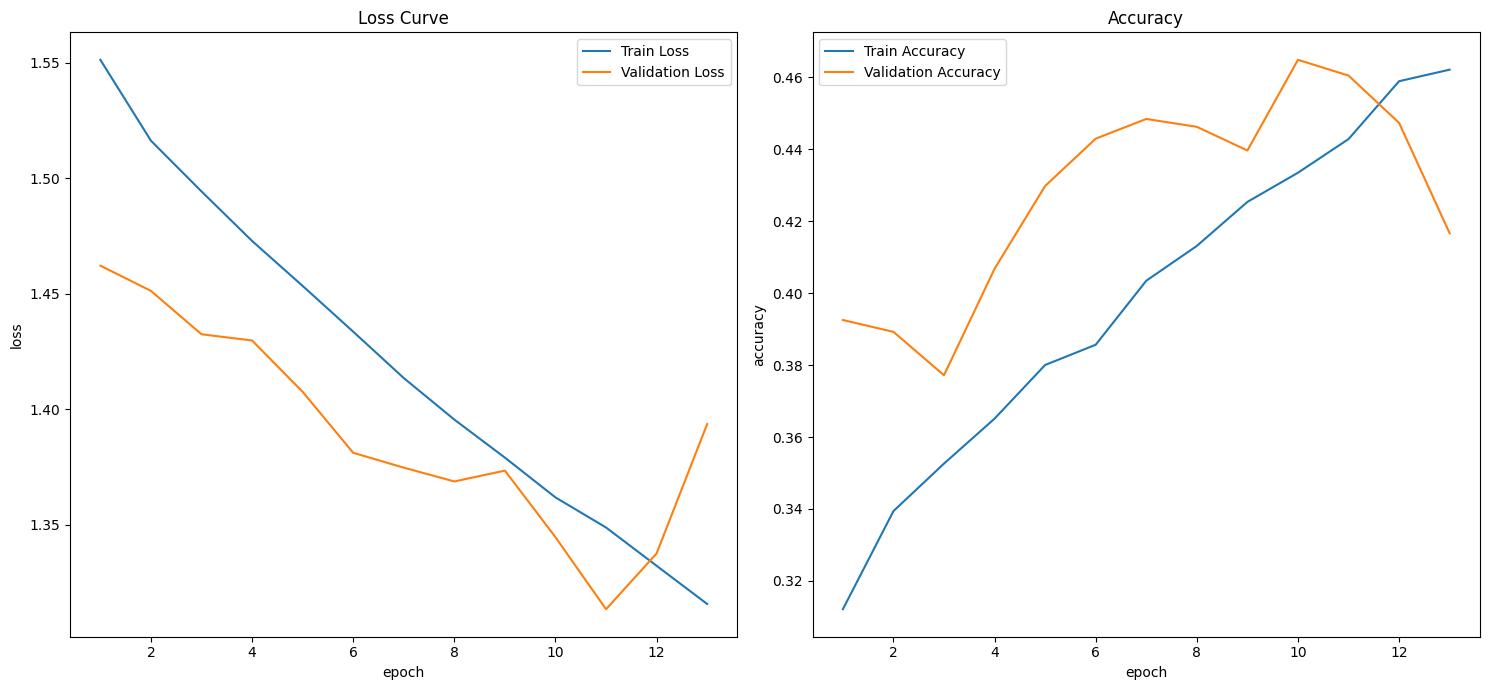

In [28]:
plt.figure(figsize=(15, 7))
epoch = results["epoch"]
loss = results["train_loss"]
acc = results["train_acc"]
val_loss = results["val_loss"]
val_acc = results["val_acc"]

plt.subplot(1, 2, 1)
plt.plot(epoch, loss, label="Train Loss")
plt.plot(epoch, val_loss, label="Validation Loss")
plt.title(f"Loss Curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch, acc, label="Train Accuracy")
plt.plot(epoch, val_acc, label="Validation Accuracy")
plt.title(f"Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("Learning_Curve.png")
plt.show()